In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json

from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import *
import time
from datetime import datetime
import os
from torch.utils import data
import random
import copy
import itertools
import io
import uuid
from sklearn.model_selection import KFold, train_test_split
import warnings
warnings.filterwarnings('ignore')

import wandb
wandb_username = 'andreasabo'
local_username = 'andreasabo'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:1') 
else:
    device = torch.device('cpu')

print(device)

cuda:1


In [3]:
# root directory
root_dir = "/home/andreasabo/Documents/HNProject/"
split_file_base = "/home/andreasabo/Documents/HNUltra/"

# data directory on current machine: abhishekmoturu, andreasabo, denizjafari, navidkorhani
data_dir = "/home/" + local_username + "/Documents/HNProject/all_label_img/"

# read target df
csv_path = os.path.join(root_dir, "all_splits_1000000.csv")
data_df = pd.read_csv(csv_path, usecols=['subj_id', 'scan_num', 'view_label', 'image_ids', 'reflux_label', 'function_label', 'surgery_label', 'outcome_train', 'view_train'])

In [4]:
print(data_df.head())
len(data_df)

  function_label image_ids reflux_label surgery_label view_label  subj_id  \
0        Missing  1323_2_1      Missing       Missing    Missing     1323   
1        Missing  1323_2_2      Missing       Missing    Missing     1323   
2        Missing  1323_2_3      Missing       Missing    Missing     1323   
3        Missing  1323_2_4      Missing       Missing    Missing     1323   
4        Missing  1323_2_5      Missing       Missing    Missing     1323   

   scan_num  outcome_train  view_train  
0         2            NaN         NaN  
1         2            NaN         NaN  
2         2            NaN         NaN  
3         2            NaN         NaN  
4         2            NaN         NaN  


72459

### **Reading Data Indicies and Labels**

In [5]:
# data_df = data_df[data_df.view_label != "Missing"]
# data_df = data_df[data_df.view_label != "Other"]
train_df = data_df[data_df.outcome_train == 1]
test_df = data_df[data_df.outcome_train == 0]

num_train_subj = len(train_df.subj_id.unique())
num_test_subj = len(test_df.subj_id.unique())
print(num_train_subj, num_test_subj)
print(train_df.head)

56 15
<bound method NDFrame.head of       function_label  image_ids reflux_label surgery_label      view_label  \
72                41  1068_1_31           No            No  Saggital_Right   
75                41  1068_1_34           No            No  Saggital_Right   
76                41  1068_1_35           No            No  Saggital_Right   
77                41  1068_1_36           No            No  Saggital_Right   
78                41  1068_1_37           No            No  Saggital_Right   
...              ...        ...          ...           ...             ...   
72453        Missing  1066_7_49          Yes            No   Saggital_Left   
72454        Missing  1066_7_50          Yes            No   Saggital_Left   
72455        Missing  1066_7_51          Yes            No   Saggital_Left   
72456        Missing  1066_7_52          Yes            No   Saggital_Left   
72457        Missing  1066_7_53          Yes            No   Saggital_Left   

       subj_id  scan_num  o

In [6]:
# Drop the images for which we do not have view labels or the label is "other"
data_df = data_df[data_df.view_label != "Missing"]
data_df = data_df[data_df.view_label != "Other"]
train_df = data_df[data_df.outcome_train == 1]
test_df = data_df[data_df.outcome_train == 0]

print(f"We have {len(test_df) + len(train_df)} images ({len(train_df)} train and {len(test_df)} test)")
unique_subj = train_df.subj_id.unique()

# Create the splits for 5-fold cross validation based on subj_id
data_split_file = split_file_base + 'data_splits_outcome_v3.json'
if not os.path.isfile(data_split_file):
    bad_split = 1
    rand_state = 0
    while bad_split:
        print(rand_state)
        bad_split = 0
        kf = KFold(n_splits=5, random_state=rand_state, shuffle=True)
        rand_state += 1
        fold = 0
        all_folds = {}
        for train_subj, val_subj in kf.split(unique_subj):
            train_ids  = unique_subj[train_subj]
            val_ids = unique_subj[val_subj]

            # Save the image names
            train_images = train_df[train_df.subj_id.isin(train_ids)].image_ids.tolist()
            val_images = train_df[train_df.subj_id.isin(val_ids)].image_ids.tolist()

            # Save the scan number
            train_scan = train_df[train_df.subj_id.isin(train_ids)].scan_num.tolist()
            val_scan = train_df[train_df.subj_id.isin(val_ids)].scan_num.tolist()

            # Save the view 
            train_views = train_df[train_df.subj_id.isin(train_ids)].view_label.tolist()
            val_views = train_df[train_df.subj_id.isin(val_ids)].view_label.tolist()



            # Save the outcome labels
            train_function = train_df[train_df.subj_id.isin(train_ids)].function_label.tolist()
            val_function = train_df[train_df.subj_id.isin(val_ids)].function_label.tolist()

            train_reflux = train_df[train_df.subj_id.isin(train_ids)].reflux_label.tolist()
            val_reflux = train_df[train_df.subj_id.isin(val_ids)].reflux_label.tolist() 

            train_surgery = train_df[train_df.subj_id.isin(train_ids)].surgery_label.tolist()
            val_surgery = train_df[train_df.subj_id.isin(val_ids)].surgery_label.tolist()

            # Check that we have at least one example of each class in the train/val set
            if len(set(train_reflux)) != len(set(val_reflux)) or len(set(train_surgery)) != len(set(val_surgery)):
                bad_split = 1
            
            train_set= set(train_function)
            train_set.remove("Missing")           
            val_set= set(val_function)
            val_set.remove("Missing")
            train_function_bin = np.asarray(list(train_set)).astype(int)
            val_function_bin = np.array(list(val_set)).astype(int)
            train_function_bin = train_function_bin[np.where(train_function_bin > 40)]
            train_sum = len(train_function_bin[np.where(train_function_bin < 60)])
            
            val_function_bin = val_function_bin[np.where(val_function_bin > 40)]
            val_sum = len(val_function_bin[np.where(val_function_bin < 60)])            
#             val_sum = np.sum(np.where(40 < val_function_bin < 60  ))
            if val_sum != len(val_function_bin) and val_sum != 0 and train_sum != len(train_function_bin) and train_sum != 0:
                bad_split = 1

                
            val_labels = train_df[train_df.subj_id.isin(val_ids)].view_label.tolist()
            cur_fold = {'train_images': train_images, 'val_images': val_images, 'train_reflux': train_reflux, 
                        'val_reflux': val_reflux, 'train_function': train_function, 'val_function': val_function, 
                        'train_surgery': train_surgery, 'val_surgery': val_surgery, 'train_scan': train_scan,
                        'val_scan': val_scan, 'train_views': train_views, 'val_views': val_views}

            all_folds[fold] = cur_fold
            fold += 1

    print("Saving data splits")
    with open(data_split_file, 'w') as f:
        json.dump(all_folds, f)
        
else: # just load from file
    print("Reading splits from file")
    with open(data_split_file, 'r') as f:
        all_folds = json.load(f)

We have 9581 images (7230 train and 2351 test)
Reading splits from file


In [7]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset: right_sag, right_trav, left_sag, left_trav, bladder, other
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 100

# Number of epochs to train for
num_epochs = 75

# Flag for feature extracting. When False, we finetune the whole model; when True we only update the reshaped layer params
feature_extract = False

# Flag for whether or not to use pretrained model
pretrain = False

# Flag for whether or not to sample sets of images by scan (ensures that all scans are seen the same number of times)
sample_by_scan = True


In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract,layers_to_train, use_pretrained=True, num_input_channels = 1):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        source for conv1: https://discuss.pytorch.org/t/grayscale-images-for-resenet-and-deeplabv3/48693/2
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, layers_to_train)
        num_ftrs = model_ft.fc.in_features
        model_ft.conv1 =  nn.Conv2d(num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model_ft.fc = nn.Sequential(
#             nn.Dropout(0.25),
            nn.Linear(num_ftrs, num_classes),
        )
                input_size = 256

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
# Code from: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=True):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [12]:
import random
class ScanDataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, image_list, reflux_labels, surgery_labels, function_labels, view_labels, scan_labels, binarize_labels = True, transformations=None, sample_by_scan=True, target_view=None):
        'Initialization'
        self.image_list = image_list
        self.subj_id = np.asarray([int(s[0:4]) for s in image_list])

        self.reflux_labels = reflux_labels        
        self.surgery_labels = surgery_labels
        self.function_labels = function_labels       
        self.view_labels = view_labels
        self.scan_labels = np.asarray(scan_labels)
        self.binarize_labels = binarize_labels
        self.transformations = transformations
        self.sample_by_scan = sample_by_scan
        self.target_view = target_view
        self.image_return_order = ['Saggital_Right', 'Transverse_Right', 'Saggital_Left', 'Transverse_Left', 'Bladder']
        
        # Create a list of indices that we will access the images in
        random.seed(0)
        list_of_inds = [num for num in range(len(image_list))]
        
        # UPDATE: don't need this since the dataloader shuffles for us
        #random.shuffle(list_of_inds) #shuffle method

        self.index_order = list_of_inds
        self.all_view_names = list(set((view_labels)))
        
        # If we are going to group by scans, create the scan list
        self.all_scan_ids = np.asarray([(str(self.subj_id[i]) + "_" + str(self.scan_labels[i])) for i in range(len(self.scan_labels))])
        self.unique_scans = list(set(self.all_scan_ids))
        
        if target_view is not None:
            self.images_of_view = []
            for ind, v in enumerate(view_labels):
                if v == target_view:
                    self.images_of_view.append(ind)

        
  def __len__(self):
        'Denotes the total number of image_list or scan_list'
        if self.target_view is not None:
            return len(self.images_of_view)
        
        if self.sample_by_scan:
            return len(self.unique_scans)
        else:
            return len(self.image_list)

  def __getitem__(self, ind):
        'Generates one sample of data'
        output_image_path_dict = {}
        if not self.sample_by_scan and self.target_view is not None:
            index = self.images_of_view[ind]
            output_image_path_dict[self.target_view] = data_dir + self.image_list[index] + '.jpg'
        
        else:
            if self.sample_by_scan:
                cur_scan = self.unique_scans[ind]
                images_of_scan = (self.all_scan_ids == cur_scan)
                indexes_in_scan = [i for i, x in enumerate(images_of_scan) if x]
                index = indexes_in_scan[0] # For now, just take the first index

            else:
                # Select sample based on current images
                index = self.index_order[ind]
                image_id = self.image_list[index]

                # We want to use the current image, as well as images from the same scan (from the same patient)
                # To fill images of the other 4 classes of images
                # First finds all of the images in this scan
                images_of_scan = (self.subj_id == self.subj_id[index]) & (self.scan_labels == self.scan_labels[index])
                indexes_in_scan = [i for i, x in enumerate(images_of_scan) if x]

            # Group images in the scan by view and select one of each (if available)
            dict_of_scans_by_view = {}
            # looping through views
            for inds in indexes_in_scan:
                if self.view_labels[inds] not in dict_of_scans_by_view:
                    dict_of_scans_by_view[self.view_labels[inds]] = [inds]
                else:
                    dict_of_scans_by_view[self.view_labels[inds]].append(inds)

            # If we directly picked an image, make sure this one is the only one for the view
            if not self.sample_by_scan:
                dict_of_scans_by_view[self.view_labels[index]] = [index]


            output_image_path_dict = {}
            # Now loop through all the views and randomly select an image.  
            for view in dict_of_scans_by_view:
                    
                    random_view_from_scan_ind = random.choice(dict_of_scans_by_view[view])
                    output_image_path_dict[view] = data_dir + self.image_list[random_view_from_scan_ind] + '.jpg'
                    
                    # Make sure we load the outcomes from the correct side
                    if self.target_view is view and self.sample_by_scan:
                        index = random_view_from_scan_ind
                    

        output_images = []
        for view in self.image_return_order:
            if view not in output_image_path_dict:
                empty_im = [np.ones((256, 256))*np.nan]
                empty_im = torch.FloatTensor(empty_im)
                output_images.append( empty_im)
            else:
                image = Image.open(output_image_path_dict[view]).convert('L')
                if self.transformations:
                    image = self.transformations(image)
                image = ToTensor()(image)
                output_images.append(image)



        y = [self.reflux_labels[index], self.surgery_labels[index], self.function_labels[index]]
        for i, outcome in enumerate(y):
            # Convert "yes" and "no" to 0/1
            if outcome == "No":
                y[i] = 0
            elif outcome == "Yes":
                y[i] = 1
            elif outcome == "Missing":
                y[i] = np.nan

            # Should we also binarize the function labels?
            elif self.binarize_labels:
                if float(outcome) > 60 or float(outcome) < 40:
                    y[i] = 1
                else:
                    y[i] = 0
            else:
                y[i] = float(outcome)

        y = torch.FloatTensor(y)
        output_images = torch.stack(output_images)
        return output_images, y



In [13]:
def train_model(model, dataloaders, criterion, optimizer, view_to_use, num_epochs=2, is_inception=False, final_testing=False):
    es = EarlyStopping(patience = 20)
    stop_now = 0
    results_dict = {}
    
    all_views = ['Saggital_Right', 'Transverse_Right', 'Saggital_Left', 'Transverse_Left', 'Bladder']

    if view_to_use not in all_views:
        print(f"View {view_to_use} does not exist")
        return
    
    view_index = all_views.index(view_to_use)
    since = time.time()
    
    classnames = ['Reflux', 'Surgery', 'Function']
    val_acc_history = []
    
    val_metrics_list = []
    train_metrics_list = []
    best_auprc = 0
    best_epoch = 0
    lowest_loss = 999999
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accs = [0.0]*3
    epoch_with_best_val_acc = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 54)

        if stop_now:
            break
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                if epoch % 1 is not 0:
                    continue
            running_loss = 0.0
            running_corrects = 0
            
            running_preds = []
            running_labels = []
            
            running_num_samples = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 labels = labels.type(torch.long)
                # Only use the image for the specified view 
                inputs = inputs[:, view_index, :, :]
#                 inputs = inputs.squeeze()
#                 print("-"*45)
                
                # Remove the indices with missing images
                input_sums = torch.sum(torch.sum(torch.sum(torch.isnan(inputs), 1), 1), 1)
                inputs_good = inputs[input_sums < 1, :, :, :]
                labels_good = labels[input_sums < 1, :]
#                 print(inputs_good.shape)
                # Create a mask of whether we have each an outcome label at each label index
                label_missing = torch.isnan(labels_good)

                inputs = inputs_good.to(device)
                labels = labels_good.to(device)
                label_missing = label_missing.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                 # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        
                        
                        running_preds += outputs.tolist()
                        running_labels += labels.tolist()
                        
                        # multiply the outputs and labels by the label mask so that missing labels do not contribute 
                        # to loss
                        outputs_for_loss = outputs * (~label_missing)
                        outputs_for_loss[abs(outputs_for_loss) < 0.000001] = 0
                        labels_for_loss = labels.clone()
                        labels_for_loss[labels_for_loss != labels_for_loss] = 0
                    
                        # Create a weights matrix so that we can place higher value on the function outcome
                        # which is often missing
                        loss_weights = torch.ones_like(outputs)
                        loss_weights[label_missing] = 0
                        col_sum = torch.sum(loss_weights, 0)
                        loss_weights = (loss_weights / col_sum) * inputs.size(0)
                        loss_weights[loss_weights > 1] = 1.5
                        #print(loss_weights)
                        criterion = nn.BCEWithLogitsLoss(weight=loss_weights)
#                         criterion = nn.BCEWithLogitsLoss()
                        loss = criterion(outputs_for_loss, labels_for_loss)
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_num_samples += inputs.size(0)
                
            # Epoch is done    
            epoch_loss = running_loss / running_num_samples
            
            # Calculate AUROC and AUPRC for each outcome
            results_dict.update({phase + '_loss': epoch_loss})
            preds = np.asarray(running_preds)
            true_labels = np.asarray(running_labels)
            
            sum_auc = 0
            sum_ave_prec = 0
            # source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            precision = dict()
            recall = dict()
            no_skill = dict()
            average_precision = dict()
            only_one_class = 0
            for ind, cl in enumerate(classnames):
                try:

                    # Remove the nans when computing metrics
                    true_outcome_labels = true_labels[:, ind]
                    predicted_outcome_labels = preds[:, ind]
                    non_nan_locs = np.squeeze(np.argwhere(~np.isnan(true_outcome_labels)))
                    true_outcome_labels = true_outcome_labels[non_nan_locs]
                    predicted_outcome_labels = predicted_outcome_labels[non_nan_locs]

                    auroc = roc_auc_score(true_outcome_labels, predicted_outcome_labels)
                    auprc = average_precision_score(true_outcome_labels, predicted_outcome_labels)
                    results_dict[phase+ "_" + cl+"_auroc"] = auroc
                    results_dict[phase+ "_" + cl+"_auprc"] = auprc
                    sum_auc += auroc


                    fpr[cl], tpr[cl], _ = roc_curve(true_outcome_labels, predicted_outcome_labels)
                    precision[cl], recall[cl], _ = precision_recall_curve(true_outcome_labels, predicted_outcome_labels)
                    roc_auc[cl] = auroc
                    average_precision[cl] = auprc
                    no_skill[cl] = len(true_outcome_labels[true_outcome_labels==1]) / len(true_outcome_labels)

                    sum_ave_prec += auprc

                    results_dict[phase+"_"+cl +"_auroc"] = auroc
                    results_dict[phase+"_"+cl +"_auprc"] = auprc                


                except:
                    only_one_class = 1
                    
                results_dict[phase+"_sum_auroc"] = sum_auc
                results_dict[phase+"_sum_auprc"] = sum_ave_prec
#             plt.figure()
#             lw = 2
#             if not only_one_class:
#                 for cl in classnames:
#                     plt.plot(fpr[cl], tpr[cl], 
#                              lw=lw, label=cl + '  ROC curve (area = %0.2f)' % roc_auc[cl])
#     #                 plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#                     plt.xlim([0.0, 1.0])
#                     plt.ylim([0.0, 1.05])
#                     plt.xlabel('False Positive Rate')
#                     plt.ylabel('True Positive Rate')
#                     plt.title(phase + ' ROC of Outcomes, Epoch: ' + str(epoch))
#                     plt.legend(loc="lower right")
#     #             plt.show()

#                 # Logging to wandb for analysis 
#                 wandb.log({phase + "_auroc_plot_"+ str(epoch): wandb.Image(plt)}, step=epoch)

#                 plt.figure()
#                 lw = 2
#                 #source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
#                 for cl in classnames:

#                     plt.plot(recall[cl], precision[cl], 
#                              lw=lw, label=cl + '  PR curve (area = %0.2f)' % average_precision[cl])
#     #                 plt.plot([0, 1], [no_skill[cl], no_skill[cl]], color='navy', lw = lw, linestyle='--', label='No Skill')

#                     plt.xlim([0.0, 1.0])
#                     plt.ylim([0.0, 1.05])
#                     plt.xlabel('Recall')
#                     plt.ylabel('Precision')
#                     plt.title(phase + ' Precision-Recall Curve of Outcomes, Epoch: '+ str(epoch))
#                     plt.legend(loc="upper right")
#     #             plt.show()
#                 wandb.log({phase + "_auprc_plot_"+ str(epoch): wandb.Image(plt), "epoch": epoch}, step=epoch)
            
            wandb.log(results_dict, step=epoch)
            
            
            if phase == "val" and best_auprc < sum_ave_prec:
                lowest_loss = epoch_loss
                best_epoch = epoch
                best_auprc = sum_ave_prec
                results_dict.update({"best_epoch":best_epoch})
                wandb.log(results_dict, step=epoch)

                metrics_from_best_epoch = copy.deepcopy(results_dict)
                print(metrics_from_best_epoch)
            print('{} loss:\t{:.4f} | {} sum of auc:\t{:.4f} \n'.format(phase, epoch_loss, phase, sum_auc))
            
            if phase == 'val':
                if es.step(sum_ave_prec) and not final_testing:
                    stop_now = 1
                    print("EARLY STOPPING " + str(epoch))
                    break
    
    return metrics_from_best_epoch


# all_views = ['Saggital_Right', 'Transverse_Right', 'Saggital_Left', 'Transverse_Left', 'Bladder']
# view_to_use = 'Saggital_Left' 
# fold = '0'
# # Use the first fold for now
# partition = all_folds[fold]

# # Test out dataloaders
# shuffle = True
# num_workers = 0
# binarize_outcomes = True
# params = {'batch_size': batch_size,
#           'shuffle': shuffle,
#           'num_workers': num_workers}

# # Tranforms
# trans = transforms.Compose([transforms.RandomAffine(degrees=8, translate=(0.1, 0.1), scale=(0.95,1.25))])

# # Generators
# training_set = ScanDataset(partition['train_images'], partition['train_reflux'], partition['train_surgery'],
#                        partition['train_function'], partition['train_views'],partition['train_scan'], binarize_outcomes, trans, sample_by_scan)
# val_set = ScanDataset(partition['val_images'], partition['val_reflux'], partition['val_surgery'],
#                        partition['val_function'], partition['val_views'],partition['val_scan'], binarize_outcomes, trans, sample_by_scan, target_view=view_to_use)

# training_generator = data.DataLoader(training_set, **params)
# val_generator = data.DataLoader(val_set, **params)


# dataloaders_dict = {'train': training_generator, 'val': val_generator}


# random_str = str(uuid.uuid4()).split("-")[0]

# wandb.init(project='hnultra_outcome', entity=wandb_username, name=view_to_use + '_fold_' + fold, group=random_str)



# lr = 0.001
# wd = 0.001


# model_ft, _ = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# model_ft = model_ft.to(device)
# wandb.watch(model_ft)

# # print(model)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model_ft.parameters(), lr=lr, weight_decay=wd)
# train_model(model_ft, dataloaders_dict, criterion, optimizer, view_to_use, num_epochs=200, is_inception=False, final_testing=False)


In [14]:
def train5fold(view_to_use, network_configs, model_name, lr, wd, amsgrad, feature_extract,layer, i):
    random_str = str(uuid.uuid4()).split("-")[0]
    binarize_outcomes = True
    folds = ['0', '1', '2', '3', '4']
    project = 'hnultra_weigh_function_0.25_no_data_augment_min30_epochs'
    group = random_str + '_' + view_to_use
    
    best_metrics_per_fold = []
    for fold in folds:

        now = datetime.now()
        date_time = now.strftime("%d-%m-%Y.%H:%M:%S")
        wandb.init(project=project, entity=wandb_username, name='fold_' + fold, group=group)
        partition = all_folds[fold]

        model_ft, _ = initialize_model(model_name, num_classes, feature_extract,layer, use_pretrained=True)
        model_ft = model_ft.to(device)
        wandb.watch(model_ft)

        # Gather the parameters to be optimized/updated in this run. If we are
        #  finetuning we will be updating all parameters. However, if we are
        #  doing feature extract method, we will only update the parameters
        #  that we have just initialized, i.e. the parameters with requires_grad
        #  is True.
        params_to_update = model_ft.parameters()
        #print("Params to learn:")
        if feature_extract:
            params_to_update = []
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
#                     print("\t",name)
        else:
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    pass
#                     print("\t",name)
#         print(model_ft)
        # Observe that all parameters are being optimized
#         optimizer_ft = optim.Adam(params_to_update, lr=lr, weight_decay=wd, amsgrad=amsgrad)

        # Setup the loss fxn
#         criterion = nn.CrossEntropyLoss()

        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=lr, weight_decay=wd)
        
        shuffle = True
        num_workers = 0
        params = {'batch_size': batch_size,
                  'shuffle': shuffle,
                  'num_workers': num_workers}

        config_dict = {'layer': layer, 'i': i, 'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'fold': int(fold),
                       'lr': lr, 'wd': wd, 'amsgrad': amsgrad, 'model_name': model_name, 'num_classes': num_classes, 
                       'num_epochs': num_epochs, 'feature_extract': feature_extract, "pretrain": pretrain, 'view': view_to_use }

        wandb.config.update(config_dict)
        # Tranforms
        # Tranforms
        trans = transforms.Compose([transforms.RandomAffine(degrees=8, translate=(0.1, 0.1), scale=(0.95,1.25))])

        # Generators
        training_set = ScanDataset(partition['train_images'], partition['train_reflux'], partition['train_surgery'],
                               partition['train_function'], partition['train_views'],partition['train_scan'], binarize_outcomes, None, sample_by_scan=True, )
        val_set = ScanDataset(partition['val_images'], partition['val_reflux'], partition['val_surgery'],
                               partition['val_function'], partition['val_views'],partition['val_scan'], binarize_outcomes, None, False, target_view=view_to_use)

        training_generator = data.DataLoader(training_set, **params)
        val_generator = data.DataLoader(val_set, **params)


        dataloaders_dict = {'train': training_generator, 'val': val_generator}

        # Train & Evaluate
        metrics_from_best_epoch = train_model(model_ft, dataloaders_dict, criterion, optimizer,  view_to_use, num_epochs, is_inception=(model_name=="inception"), final_testing = False)
        best_metrics_per_fold.append(metrics_from_best_epoch)

    # Calculate the performance metrics on the best model in each fold
    wandb.init(project=project, entity=wandb_username, name='ALL', group=group)
    config_dict['fold'] = -1
    wandb.config.update(config_dict)
    wandb.config.update(network_configs)


    metrics_all = {}
    for fold in best_metrics_per_fold:
        for key in fold:
            if key not in metrics_all:
                metrics_all[key] = [fold[key]]
            else:
                metrics_all[key].append(fold[key]) 
    # print(metrics_all)

    metrics_to_log = {}
    for m in metrics_all:
        metric_list = np.asarray(metrics_all[m])

        metrics_to_log[m + '_mean'] = metric_list.mean()    
        metrics_to_log[m + '_stdev'] = metric_list.std()

    wandb.config.update(metrics_to_log)

In [15]:
lr = 0.001
wd = 0.001
layers_to_train = [2, 4, 8, 12, 16]
amsgrad = False
i = 0
lrs = [1e-3, 1e-4, 5e-4, 1e-3]
weight_decays = [1e-4, 5e-4, 1e-5]
feature_extracts = [False, True]
for lr in lrs:
    for wd in weight_decays:
        for feature_extract in feature_extracts:
            for layer in layers_to_train:
                for view_to_use in ['Saggital_Right', 'Transverse_Right', 'Saggital_Left', 'Transverse_Left']:
                    if i >= 0:
                        train5fold(view_to_use, {'feature_extract': feature_extract}, 'resnet', lr, wd, amsgrad, feature_extract,layer, i)
                    i += 1

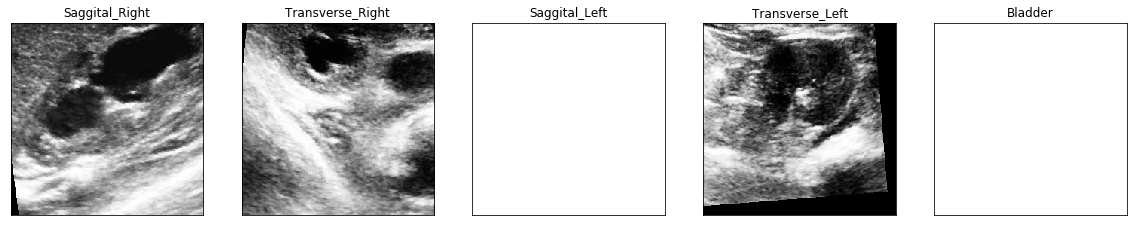

In [29]:
# # This is for visualizing images, 
# # MAKE SURE THIS IS COMMENTED OUT WHEN COMMITTING!!
# image_return_order = ['Saggital_Right', 'Transverse_Right', 'Saggital_Left', 'Transverse_Left', 'Bladder']
# view_to_use = 'Transverse_Left' 
# fold = '0'
# # Use the first fold for now
# partition = all_folds[fold]
# binarize_outcomes = True
# shuffle = True
# num_workers = 0
# params = {'batch_size': batch_size,
#           'shuffle': shuffle,
#           'num_workers': num_workers}

# # Tranforms
# # Tranforms
# trans = transforms.Compose([transforms.RandomAffine(degrees=8, translate=(0.1, 0.1), scale=(0.95,1.25))])

# # Generators
# training_set = ScanDataset(partition['train_images'], partition['train_reflux'], partition['train_surgery'],
#                        partition['train_function'], partition['train_views'],partition['train_scan'], binarize_outcomes, trans, sample_by_scan=True)
# # val_set = ScanDataset(partition['val_images'], partition['val_reflux'], partition['val_surgery'],
# #                        partition['val_function'], partition['val_views'],partition['val_scan'], binarize_outcomes, None, False, target_view=view_to_use)

# training_generator = data.DataLoader(training_set, **params)


# for inputs, labs in training_generator:
#     plt.figure(figsize=(20,10)) 
#     first_scan = inputs[0]
#     for i in range(5):
#         im = first_scan[i,:, :, :]

#         im_np = np.asarray(im).squeeze()
#         plt.subplot(1,5,i+ 1)
#         plt.imshow(im_np, cmap='gray')
#         frame1 = plt.gca()
#         frame1.axes.get_xaxis().set_visible(False)
#         frame1.axes.get_yaxis().set_visible(False)

#         plt.title(image_return_order[i])
        
        
#     break